## Comparison of EFAS forecast and the local water gauge during January 2018 floods in Cologne

#### Introduction
On January 2018, the city of Cologne has seen one of the largest floods in recent years. The flood peaked at 8th of January according to *Kölner Pegel*, the local water gauge at the city center; with a recorded value of **8.71 m**, where the typical average runs around 2-3 meters. [According to StEB](https://steb-koeln.de/hochwasser-und-ueberflutungsschutz/hochwasser/hochwassermanagement/hochwassermanagement.jsp), the waterfront of Cologne old town is expected to be flooded starting from water gauge of **8.10 m**. The picture below is taken on 8th of January, showing the part of the riverbank along the oldtown of Cologne. It also shows the Pegel itself partially flooded at the center left, in front of the trees.

<figure style="text-align:center;">
  <img src="2018-01-08-Rheinhochwasser_Januar_2018_Köln-6022_better.jpg" 
       alt="Rhine flood Cologne 2018" 
       width="850" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 1. Rhine flood in Cologne's oldtown, 8 January 2018 © Superbass / CC-BY-SA-4.0 (via Wikimedia Commons) (modified)
  </figcaption>
</figure>


#### Purpose and workflow
This notebook examines river discharge of Rhein in Cologne during the two-week period in January, centered at 8th January. The observed data from in-situ Pegel is compared to the forecast by EFAS in order to study whether the forecast was accurate. First the Pegel data will be examined. Then the forecasting data will be processed. Finally both datasets will be compared and analyzed. In doing this study, I am  inspired from local case studies shared [here](https://confluence.ecmwf.int/display/CEMS/5.3+Share+a+Case+Study). 

#### Disclaimer

Please note that this is my first ever study of a hydrology topic and such type of datasets and I claim no expertise. I learned lot of things on these topics while working on this notebook such as LISFLOSS model and Ratio curves. There might be technical mistakes in calculations or in the interpretation of outcomes. I appreciate any feedback, comments or corrections greatly!

#### Datasets
- Water gauge dataset is available [here](https://www.wasserstaende.de/gast/stammdaten?pegelnr=2730010). Discharge and height datasets are used here for the period of 1-15 January 2018.
- The EFAS forecast datasets are available upon registration to the system, a download request needs to be made after selecting the dataset of choice.
  - Reforecasted dataset: This dataset answers the question: "What would the prediction have been, if we had our current forecasting model at a past instance?". So this is supposed to be giving the best possible forecast within the limits and quality of available information at the time of interest.
    - Dataset: Joint Research Center, Copernicus Emergency Management Service (2019): Reforecasts of river discharge and related data by the European Flood Awareness System. Early Warning Data Store (EWDS). DOI: 10.24381/cds.c83f560f (Accessed on 26-08-2025) 
  - Historical dataset: This dataset uses the forecasting model to get the output values (river discharge rate etc.) but its inputs are actual realized meteorological data, in contrast to forecasts.
    - Dataset: Joint Research Center, Copernicus Emergency Management Service (2019): River discharge and related historical data from the European Flood Awareness System. Early Warning Data Store (EWDS). DOI: 10.24381/cds.e3458969 (Accessed on 24-08-2025)  



### 1 - Studying the dataset of observed values from Kölner Pegel

In [291]:
# Read-in the water level dataset and check the content
import pandas as pd
import matplotlib.pyplot as plt

W_path = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/pegelonline-kln-W-20180101-20180115.csv"

dfW = pd.read_csv(W_path, sep=";", parse_dates=["timestamp"])

print(dfW.head())

            timestamp  value
0 2018-01-01 00:00:00    470
1 2018-01-01 00:15:00    471
2 2018-01-01 00:30:00    472
3 2018-01-01 00:45:00    473
4 2018-01-01 01:00:00    474


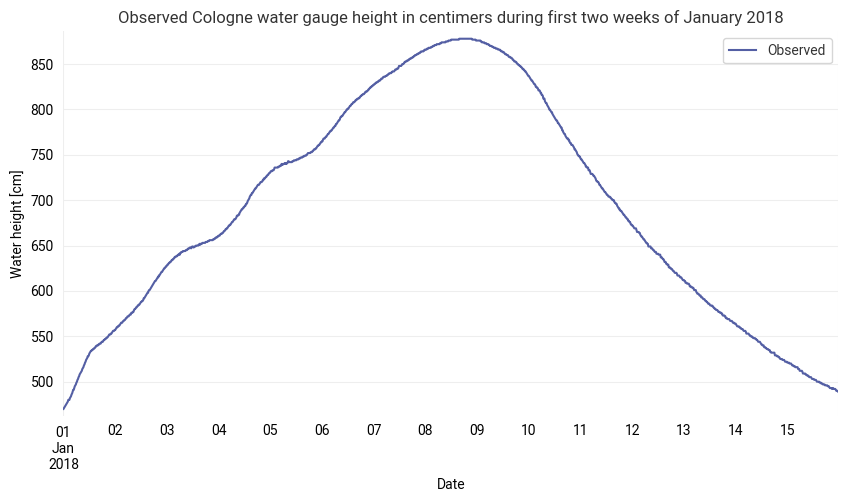

In [295]:
# Plot the observed water level

dfW.plot(x="timestamp", y="value", figsize=(10,5), grid=True, 
         title="Observed Cologne water gauge height in centimers during first two weeks of January 2018", label="Observed")
plt.xlabel("Date")
plt.ylabel("Water height [cm]")
plt.show()


It can be seen that, the water height plot is consistent with the reports saying the flooding peaked on 8th of January with a recorded level of 8.71m. This is a good check to see we are working with the right dataset

In [342]:
# Read-in the water level dataset and check the content
Q_path = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/pegelonline-kln-Q-20180101-20180115.csv"

dfQ = pd.read_csv(Q_path, sep=";", parse_dates=["timestamp"])

print(dfQ.head())

            timestamp  value
0 2018-01-01 00:00:00   3199
1 2018-01-01 00:15:00   3207
2 2018-01-01 00:30:00   3216
3 2018-01-01 00:45:00   3224
4 2018-01-01 01:00:00   3233


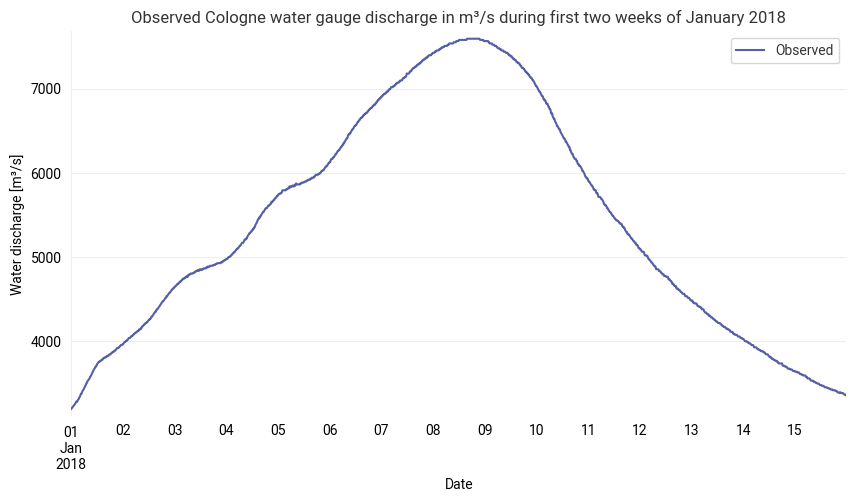

In [320]:
# Plot the observed water discharge
dfQ.plot(x="timestamp", y="value", figsize=(10,5), grid=True,
         title="Observed Cologne water gauge discharge in m³/s during first two weeks of January 2018", label="Observed")
plt.xlabel("Date")
plt.ylabel("Water discharge [m³/s]")
plt.show()

The river discharge is very strongly correlated with the water height. In fact, if we compute the Pearson correlation coefficient we can see that it is >99%.

In [293]:
# Pearson correlation coefficient
corr = dfW["value"].corr(dfQ["value"], method="pearson")
print("Correlation coefficient:", corr)

Correlation coefficient: 0.9978177925341193


This relationship between discharge and water level is expected and scientifically described with a power-law-following Rating Curve:
$$ Q = a \, (h - h_{0})^{b} $$
where

$Q$: discharge $\;\; [\tfrac{m^{3}}{s}]$  
$h$: water level (stage) [m]  
$h_{0}$: threshold stage (zero-flow level) [m]  
$a,b$: empirical coefficients (dimensionless) 

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Observed pegel data
height_cm = np.array(dfW["value"]) # W
discharge = np.array(dfQ["value"]) # Q

# Convert cm → m
height_m = height_cm / 100.0

# Define rating curve function
def rating_curve(h, a, h0, b):
    return a * np.maximum(h - h0, 0)**b

# Initial guesses and bounds
params, cov = curve_fit(
    rating_curve,
    height_m,
    discharge,
    p0=[1000, 3.5, 2],              
    bounds=([0, 0, 0.5], [1e5, 6, 5])  
)

a, h0, b = params
print(f"Fitted rating curve: Q = {a:.2f} * (h - {h0:.2f})^{b:.2f}")
print(f"Thus, a = {a:.2f}, b= {b:.2f} and h_0 = {h0:.2f}")

Fitted rating curve: Q = 344.32 * (h - 0.00)^1.42
Thus, a = 344.32, b= 1.42 and h_0 = 0.00


Amount of water discharge needed for oldtown of Cologne to be flooded can then be found by plugging in h=8.1 i.e.
Q = 6715 m³/s.

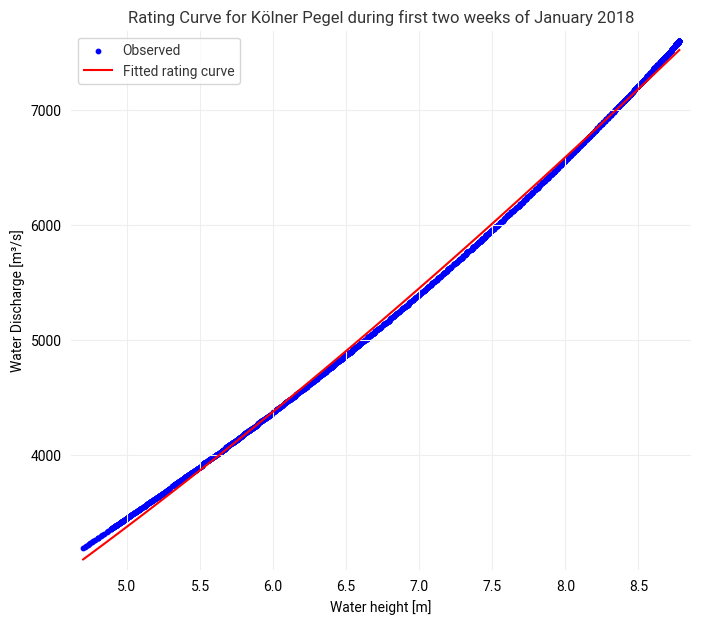

In [297]:
# Plot the rating curve
h_fit = np.linspace(min(height_m), max(height_m), 100)
q_fit = rating_curve(h_fit, *params)

plt.scatter(height_m, discharge,s=10, color="blue", label="Observed")
plt.plot(h_fit, q_fit, color="red", label="Fitted rating curve")
plt.xlabel("Water height [m]")
plt.ylabel("Water Discharge [m³/s]")
plt.title("Rating Curve for Kölner Pegel during first two weeks of January 2018")
plt.legend()
plt.grid(True)
plt.show()

b > 1 indicates that the flow accelerates with the water height. This is expected for large rivers such as Rhein as discharge is computed by

Q = (Cross-sectional flow area) X (Mean velocity) 

and more depth means more cross-sectional area and also larger velocity. The velocity increase is not as intuitional as cross-sectional area. It can be thought of as originating from a reduction in fraction of water volume getting slowed by the frictional forces of riverbed and edges. More water means, relatively less fraction of total water volume is in contact with such forces. Thus average velocity increases. For details see Manning's Equation.

### 2 - Studying the reforecasting dataset

Our dataset here is gridded. In order the compare the forecast to the in-situ pegel observation, we need to first find the grid point closest to actual location of observations. For this we take the coordinates of Kölner Pegel as the reference point.

In [298]:
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordinates of Kölner Pegel
cologne_lat, cologne_lon = 50.9369, 6.9632

The dataset has two types of values: control and ensemble, where control represent the mean and the ensemble (consisting of varied forecasts from slighly shifted initial values) is used to estimate the uncertainties.

In [311]:
# Read-in the dataset separate the two data formats
import xarray as xr

rfc_file = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/2018JanKoeln_reforecasted.grib"

# Load the ensemble and control separately
ds_cf = xr.open_dataset(
    rfc_file,
    engine="cfgrib",
    filter_by_keys={"dataType": "cf"}
)

ds_pf = xr.open_dataset(
    rfc_file,
    engine="cfgrib",
    filter_by_keys={"dataType": "pf"}
)

# Some more modifications are needed to get the program not complaining about the dataset structure:

# Give control forecast a dummy "number" dimension
ds_cf = ds_cf.expand_dims(number=[0])

# Add dataType coordinate
ds_cf = ds_cf.assign_coords(dataType="cf")
ds_pf = ds_pf.assign_coords(dataType="pf")

# Concatenate along dataType
ds = xr.concat([ds_cf, ds_pf], dim="dataType")

/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by def

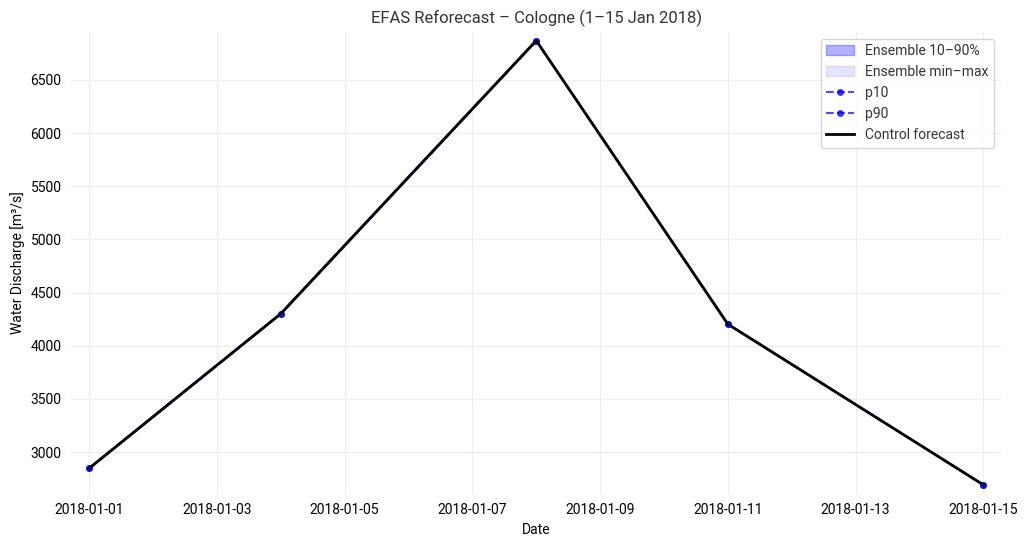

In [335]:
# Find the closest grid point in the dataset to the reference coordinate
import numpy as np
import matplotlib.pyplot as plt

# Find nearest grid point
ens_point  = ens.sel(latitude=cologne_lat, longitude=cologne_lon, method="nearest")
ctrl_point = ctrl.sel(latitude=cologne_lat, longitude=cologne_lon, method="nearest")

# Limit to 1–15 Jan 2018
ens_point  = ens_point.sel(time=slice("2018-01-01", "2018-01-15"))
ctrl_point = ctrl_point.sel(time=slice("2018-01-01", "2018-01-15"))

# Ensemble statistics (collapse ensemble dimension 'number')
ens_min  = ens_point.min(dim="number").squeeze()
ens_max  = ens_point.max(dim="number").squeeze()
ens_p10  = ens_point.quantile(0.1, dim="number").squeeze()
ens_p90  = ens_point.quantile(0.9, dim="number").squeeze()

# Control forecast = ensemble member 0
ctrl_point_ctrl = ctrl_point.sel(number=0).squeeze()
x = ctrl_point_ctrl.time.values
ctrl_y = ctrl_point_ctrl.values
ctrl_point = ctrl_point.sel(time=slice("2018-01-01", "2018-01-15"))

# Plot
plt.figure(figsize=(12,6))

# Ensemble bands (plotted behind everything else)
plt.fill_between(x, ens_p10, ens_p90, 
                 color="blue", alpha=0.3, zorder=1, label="Ensemble 10–90%")
plt.fill_between(x, ens_min, ens_max, 
                 color="blue", alpha=0.1, zorder=1, label="Ensemble min–max")

# Plot p10 and p90 as dashed lines with markers (so spread is visible)
plt.plot(x, ens_p10, "b--o", ms=4, alpha=0.7, label="p10")
plt.plot(x, ens_p90, "b--o", ms=4, alpha=0.7, label="p90")

# Control forecast
plt.plot(x, ctrl_y, color="black", lw=2, zorder=2, label="Control forecast")

plt.title("EFAS Reforecast – Cologne (1–15 Jan 2018)")
plt.ylabel("Water Discharge [m³/s]")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

Some observations:
- The reforecasted data qualitatively captures the hydrodynamics of the flood.
- The peak is nevertheless underestimated.
- There are only few data points covering this period, difficult to assess in details.
- Ensemble variations are very close to actual control value, that's why a band around the central value cannot be seen.

### 3 - Studying the historical dataset

In [330]:
efas_file = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/2018JanKoeln.grib"
efas_data = xr.open_dataset(glofas_file, engine="cfgrib")

/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [331]:
# Open the dataset
ds = xr.open_dataset(efas_file)

# Find nearest grid cell
abs_lat = np.abs(ds.latitude - cologne_lat)
abs_lon = np.abs(ds.longitude - cologne_lon)
dist = abs_lat + abs_lon
iy, ix = np.unravel_index(dist.argmin(), dist.shape)

lat_nearest = float(ds.latitude[iy])
lon_nearest = float(ds.longitude[ix])
print("Nearest grid point:", lat_nearest, lon_nearest)

# Extract discharge time serie (6h granularity)
ts = ds["dis06"].isel(latitude=iy, longitude=ix)

Nearest grid point: 50.941666000000005 6.958332999999999


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


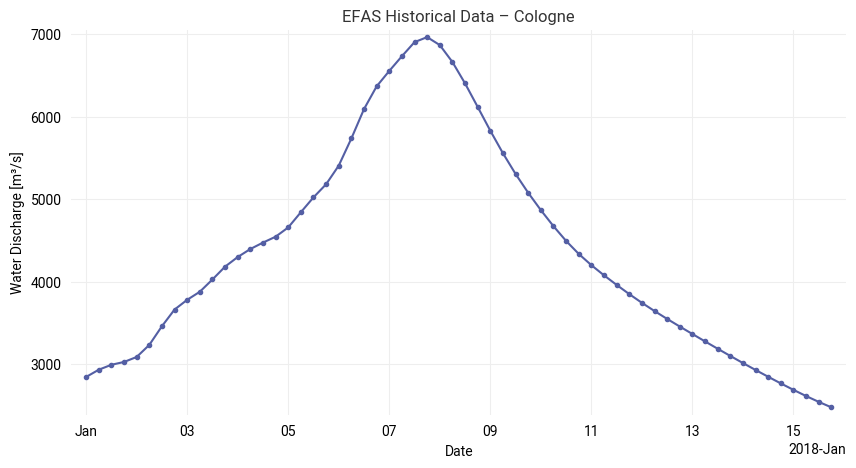

In [332]:
# Plot
plt.figure(figsize=(10,5))
ts.plot(marker=".")
plt.title(f"EFAS Historical Data – Cologne")
plt.ylabel("Water Discharge [m³/s]")
plt.xlabel("Date")
plt.grid(True)
plt.show()

- The qualitative behaviour is similar
- 24h/6h = 4 times more data points per day creates a smoother shape

### 4 - Comparison of datasets

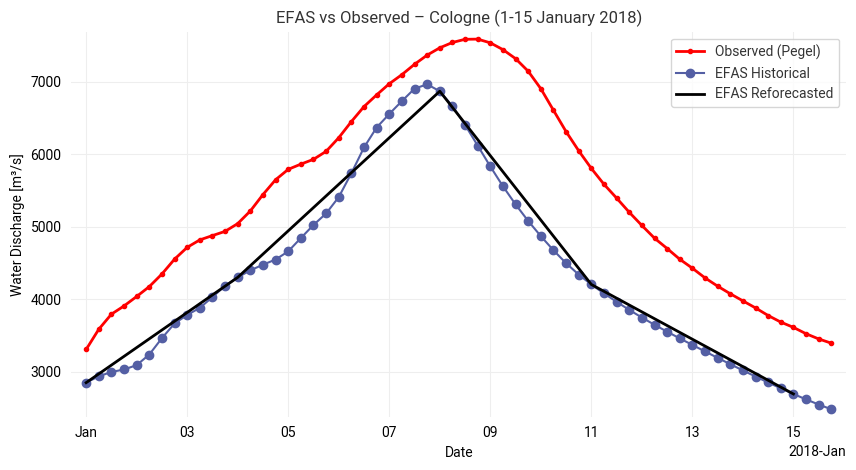

In [399]:
# Pegel data cleanup
# If "timestamp" is still a column, parse carefully:
if "timestamp" in dfQ.columns:
    # Try parsing as datetime strings, or seconds since epoch if numeric
    dfQ["timestamp"] = pd.to_datetime(
        dfQ["timestamp"], errors="coerce", infer_datetime_format=True
    )
    dfQ = dfQ.set_index("timestamp")

# Ensure index is datetime
dfQ.index = pd.to_datetime(dfQ.index, errors="coerce")

# Drop any NaT (unparsable) and any 1970 ghosts
dfQ = dfQ[ (dfQ.index >= "2018-01-01") & (dfQ.index <= "2018-01-31") ]

# 15 min data points -> 6 hour mean data points (to match granularity of dataset)
dfQ_resampled = dfQ.resample("6h").mean()

# Control forecast cleanup
x_fixed = pd.to_datetime(ctrl_point_ctrl.time.values).to_pydatetime()
ctrl_y  = ctrl_point_ctrl.values

# Plot
plt.figure(figsize=(10,5))
ax = plt.gca()

# Observed Pegel
ax.plot(dfQ_resampled.index, dfQ_resampled["value"],
        color="red", lw=2, marker="o", markersize=3,
        label="Observed (Pegel)")

# EFAS forecast (time series DataArray)
ts.plot(marker="o", ax=ax, label="EFAS Historical")

# Control forecast (fixed x-axis)
ax.plot(x_fixed, ctrl_y, color="black", lw=2, label="EFAS Reforecasted")

# Styling
plt.title("EFAS vs Observed – Cologne (1-15 January 2018)")
plt.ylabel("Water Discharge [m³/s]")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

Qualitatively, it can be clearly seen that EFAS gets the shape but not the normalization of the flood dynamics.

Let's try to quantify the comparisons:

Control forecast:
  RMSE = 951.75, R² = 0.61, Corr = 0.97, Bias = -864.01
Ensemble mean forecast (ts):
  RMSE = 1130.30, R² = 0.30, Corr = 0.95, Bias = -1047.08


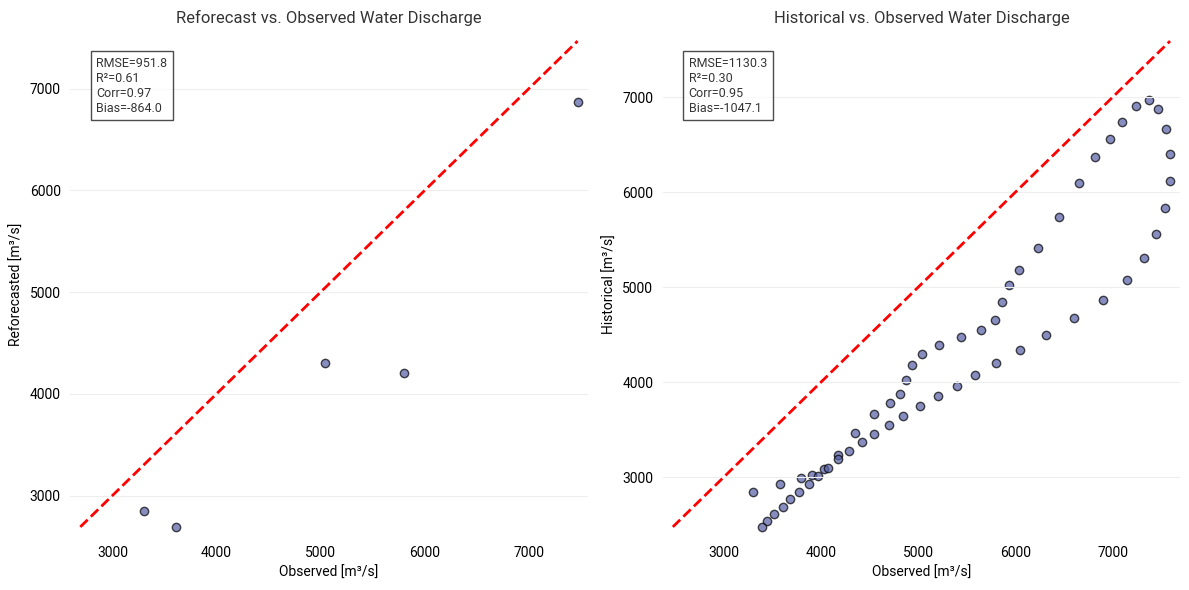

In [395]:
# Align observed with control forecast
obs = dfQ_resampled["value"]   # observed Pegel (6h mean)

# Control series
ctrl_series = pd.Series(ctrl_y, index=pd.to_datetime(x))
obs_ctrl, ctrl_aligned = obs.align(ctrl_series, join="inner")

# Ensemble mean series (ts already plotted earlier)
ts_series = pd.Series(ts.values, index=pd.to_datetime(ts.time.values))
obs_ts, ts_aligned = obs.align(ts_series, join="inner")

# Metrics function
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    corr = y_true.corr(y_pred)
    bias = (y_pred - y_true).mean()
    return rmse, r2, corr, bias

# Control metrics
rmse_c, r2_c, corr_c, bias_c = compute_metrics(obs_ctrl, ctrl_aligned)

# Ensemble mean metrics
rmse_t, r2_t, corr_t, bias_t = compute_metrics(obs_ts, ts_aligned)

print("Control forecast:")
print(f"  RMSE = {rmse_c:.2f}, R² = {r2_c:.2f}, Corr = {corr_c:.2f}, Bias = {bias_c:.2f}")
print("Ensemble mean forecast (ts):")
print(f"  RMSE = {rmse_t:.2f}, R² = {r2_t:.2f}, Corr = {corr_t:.2f}, Bias = {bias_t:.2f}")

# Scatter plots
plt.figure(figsize=(12,6))

# Control scatter
plt.subplot(1,2,1)
plt.scatter(obs_ctrl, ctrl_aligned, alpha=0.7, edgecolor="k")
lims = [min(obs_ctrl.min(), ctrl_aligned.min()), max(obs_ctrl.max(), ctrl_aligned.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title("Reforecast vs. Observed Water Discharge")
plt.xlabel("Observed [m³/s]")
plt.ylabel("Reforecasted [m³/s]")
plt.text(0.05, 0.95, f"RMSE={rmse_c:.1f}\nR²={r2_c:.2f}\nCorr={corr_c:.2f}\nBias={bias_c:.1f}",
         transform=plt.gca().transAxes, va="top", ha="left", fontsize=9,
         bbox=dict(facecolor="white", alpha=0.7))

# Ensemble mean scatter
plt.subplot(1,2,2)
plt.scatter(obs_ts, ts_aligned, alpha=0.7, edgecolor="k")
lims = [min(obs_ts.min(), ts_aligned.min()), max(obs_ts.max(), ts_aligned.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title("Historical vs. Observed Water Discharge")
plt.xlabel("Observed [m³/s]")
plt.ylabel("Historical [m³/s]")
plt.text(0.05, 0.95, f"RMSE={rmse_t:.1f}\nR²={r2_t:.2f}\nCorr={corr_t:.2f}\nBias={bias_t:.1f}",
         transform=plt.gca().transAxes, va="top", ha="left", fontsize=9,
         bbox=dict(facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

Quantitative Findings:
- Models have high correlation with the observation.
- Models underestimate the water discharge.
- Although the reforecasted dataset has less discrepancy, it should be noted that the reforecasted dataset lacks the points for where historical dataset has the worst forecast i.e. 4-6 January period. Thus, the increased performance seems  artificial, as points actually present in both forecasts indicate similar trends. 
- Discharge is almost fully correlated with the water height. Thus, it can be used to predict whether the city will be flooded or not.


### Would there be real-life consquences of water discharge underestimation?
An interesting question is, whether the underestimated water discharge forecast would have misled the authorities in an hypothetical scenario. Remembering almost full correlation between the water discharge and height, let's check if the underestimated discharge numbers still predict the flooding of the oldtown of Cologne:

- We have previously established the ratio function from Pegel data to be $$ Q = a \cdot (h - h_{0})^{b}$$
- Solving for h: $$ h = h_{0} + \left( \frac{Q}{a} \right)^{\tfrac{1}{b}} $$

In [374]:
# Write a function to calculate water height from discharge
def h_from_Q(Q):
    """
    Compute water stage (h) from discharge (Q) 
    using rating curve: Q = 344.32 * (h)^1.42
    """
    a = 344.32
    b = 1.42
    h0 = 0.0  # threshold

    return ((Q / a) ** (1 / b)) + h0

In [398]:
# Maximum of the reforecasted data
ctrl_max = ctrl_series.max().item()
print("Maximum reforecasted discharge:", ctrl_max)

# Calculate the water height at oldtown
print("Maximum reforecasted water height:", h_from_Q(ctrl_max))
print("Difference between observed maximum and reforecasted maximum (m):", 8.71-h_from_Q(ctrl_max))

Maximum reforecasted discharge: 6869.166015625
Maximum reforecasted water height: 8.230987568544585
Difference between observed maximum and reforecasted maximum (m): 0.4790124314554163


- Whether there will be flooding: Since flooding of the old town requires h>8.1m, the reforecasted model maximum of >8.2m still indicated that the old town would be flooded. However, the forecast underestimated the absolute maximum by about 0.5 m compared to the observed peak. With a little less discharge, the model could have had failed to predict flooding.

- Timing of the flooding: The threshold of 8.1 m corresponds to a discharge of about 6715 m³/s. The Pegel surpassed this threshold on 6 January, whereas the forecast only reached it on 7 January. Thus, the model predicted flooding of Cologne’s old town one day later than it actually occurred.

### 5 Conclusions and open questions

The ECMWF model for flood forecasting based on LISFLOSS works extremely successful, given the scale of geography and the various parameters it needs to take into account to calculate this single metric we studied here. Despite that, there is room for improvement that could affect the real-world outcomes.

Open questions:
- The discrepancies are studied for a very narrow time window which was also a period of heightened hydrolic activity. It is unclear if these trends generalize for larger time intervals and/or lower hydrolic activity periods.
- Origin of discrepancies themselves are also unclear. The forecasts are from LISFLOOD tool and it has multiple inputs. Studying the relative contribution of the inputs for the data points here and looking for a pattern for when forecasts are close/away might provide some insights.